In [1]:
import os, sys, time, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import optuna
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)
from optuna.pruners import MedianPruner

# -------------- 0. housekeeping  --------------------------------
k_folds    = 5
max_trials = 1000                    # try up to 1000 trials, but we can interrupt early
os.makedirs("figures", exist_ok=True)

# Redirect stdout to both console + log file
class Tee:
    def __init__(self, *streams):
        self.streams = streams
    def write(self, data):
        for s in self.streams:
            s.write(data)
            s.flush()
    def flush(self):
        for s in self.streams:
            s.flush()

log_file = open("output.txt", "w")
sys.stdout = Tee(sys.__stdout__, log_file)

print(f"Settings  |  k_folds = {k_folds},  max_trials = {max_trials}\n")

# -------------- 1. load data -----------------------------------
sys.path.append(
    r"C:\Users\flori\OneDrive - TU Eindhoven\Master TUe 2024-2025\1BM120 - Decision Making with Artificial Intelligence\Assignment 2"
)
from support import load_dataset

trainset, testset = load_dataset()
num_classes = len(trainset.classes)
print(f"Loaded  |  train = {len(trainset)},  test = {len(testset)}")
print("Classes :", trainset.classes, "\n")

# -------------- 2. define CNN ----------------------------------
class CNN_CV(nn.Module):
    def __init__(self, n_cls, pooltype=0):
        super().__init__()
        self.conv1  = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1  = nn.ReLU()
        if pooltype == 0:
            self.pool1 = nn.MaxPool2d(2, 2)
        else:
            self.pool1 = nn.AvgPool2d(2, 2)

        self.conv2  = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.relu2  = nn.ReLU()
        if pooltype == 0:
            self.pool2 = nn.MaxPool2d(2, 2)
        else:
            self.pool2 = nn.AvgPool2d(2, 2)

        # After two 2×2 pools: 60×30 → 30×15 → 15×7, channels=16
        self.fc1     = nn.Linear(16 * 15 * 7, n_cls)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)
        return self.fc1(x)    # raw logits

# -------------- 3. CV + pruning routine ------------------------
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

def cross_validate(lr, wd, pooltype, bs, epochs, trial_id, trial=None):
    """
    Runs k-fold CV, reporting intermediate val‐loss for pruning.
    Returns: mean CV loss, avg_train_curve, avg_val_curve, fold_val_losses.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_val_losses  = []
    fold_train_epoch = []
    fold_val_epoch   = []

    splits = list(kf.split(trainset))
    for fold, (tr_idx, val_idx) in enumerate(splits, start=1):
        print(f"-- Fold {fold}/{k_folds}  (trial {trial_id})  |  lr={lr:.1e}, wd={wd:.1e}, pool={'max' if pooltype==0 else 'avg'}, bs={bs}, ep={epochs}")

        trainset_CV = Subset(trainset, tr_idx)
        valset_CV   = Subset(trainset, val_idx)
        tr_loader   = DataLoader(trainset_CV, batch_size=bs, shuffle=True,  pin_memory=True, num_workers=4)
        vl_loader   = DataLoader(valset_CV,   batch_size=bs, shuffle=False, pin_memory=True, num_workers=4)

        model_CV = CNN_CV(num_classes, pooltype).to(device)
        optimizer = optim.Adam(model_CV.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()

        tr_curve = []
        vl_curve = []

        for ep in range(1, epochs + 1):
            # ---------- TRAIN ----------
            model_CV.train()
            running_loss, correct = 0.0, 0
            for xb, yb in tr_loader:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                optimizer.zero_grad()
                logits = model_CV(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()

            tr_loss = running_loss / len(tr_loader)
            tr_acc  = 100.0 * correct / len(trainset_CV)
            tr_curve.append(tr_loss)

            # ---------- VALIDATION ----------
            model_CV.eval()
            vloss_sum, vcorrect = 0.0, 0
            with torch.no_grad():
                for xb, yb in vl_loader:
                    xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                    logits = model_CV(xb)
                    loss   = criterion(logits, yb)
                    vloss_sum += loss.item()
                    preds = logits.argmax(dim=1)
                    vcorrect += (preds == yb).sum().item()

            v_loss = vloss_sum / len(vl_loader)
            v_acc  = 100.0 * vcorrect / len(valset_CV)
            vl_curve.append(v_loss)

            # Print & update TQDM
            print(f"   Epoch {ep:02d}/{epochs}  |  train_loss={tr_loss:.4f} ({tr_acc:.1f}%)  val_loss={v_loss:.4f} ({v_acc:.1f}%)")

            # -------- PRUNE CHECK --------
            if trial is not None:
                step = (fold - 1) * epochs + ep
                trial.report(v_loss, step=step)
                if trial.should_prune():
                    print(f"   >>> Trial {trial.number+1} pruned at fold {fold}, epoch {ep} (val_loss={v_loss:.4f})")
                    raise optuna.TrialPruned()

        fold_train_epoch.append(tr_curve)
        fold_val_epoch.append(vl_curve)
        fold_val_losses.append(vl_curve[-1])
        print(f"   Fold done | final val loss = {vl_curve[-1]:.4f}\n")

    mean_cv = float(np.mean(fold_val_losses))
    print(f"*** Mean CV loss = {mean_cv:.4f} ***\n")

    avg_tr = np.mean(fold_train_epoch, axis=0)
    avg_vl = np.mean(fold_val_epoch, axis=0)
    return mean_cv, avg_tr, avg_vl, fold_val_losses

# -------------- 4. objective + callback -----------------------
history = {k: [] for k in ("lr","wd","pool","bs","ep","cv_loss","train_curve","val_curve","fold_val_losses")}

def objective(trial: optuna.Trial) -> float:
    # 4 hyperparameters to tune
    lr        = trial.suggest_float("lr", 1e-8, 1e-1, log=True)
    wd        = trial.suggest_float("wd", 1e-8, 1e-1, log=True)
    pooltype  = trial.suggest_categorical("pool", [0, 1])
    bs        = trial.suggest_categorical("bs",   [8,16,32,64,128,256])  # batch size
    ep        = trial.suggest_categorical("ep", [5,10,15,20,25,30])   # number of epochs
    t_id      = trial.number + 1

    print(f"== Trial {t_id}/{max_trials}  |  lr={lr:.1e}, wd={wd:.1e}, pool={pooltype}, bs={bs}, ep={ep}")

    try:
        cv_loss, tr_curve, vl_curve, fold_vals = cross_validate(
            lr, wd, pooltype, bs, ep, t_id, trial=trial
        )
    except optuna.TrialPruned:
        print(f"<<< Trial {t_id} pruned >>>\n")
        raise

    # store everything in history
    history["lr"].append(lr)
    history["wd"].append(wd)
    history["pool"].append(pooltype)
    history["bs"].append(bs)
    history["ep"].append(ep)
    history["cv_loss"].append(cv_loss)
    history["train_curve"].append(tr_curve)
    history["val_curve"].append(vl_curve)
    history["fold_val_losses"].append(fold_vals)

    # save learning‐curve figure for this specific trial
    fig, ax = plt.subplots()
    ax.plot(range(1, ep+1), tr_curve, label="train")
    ax.plot(range(1, ep+1), vl_curve, label="val")
    ax.set_xlabel("epoch"); ax.set_ylabel("loss")
    ax.set_title(f"Learning curve | trial {t_id}")
    ax.legend()
    #fig.tight_layout()
    fig.savefig(f"figures/learning_curve_trial_{t_id}.png")
    plt.close(fig)

    return cv_loss

def after_trial_callback(study: optuna.Study, trial: optuna.Trial) -> None:
    t_id       = trial.number + 1
    best_p     = study.best_params
    best_val   = study.best_value
    print(f"   --> After Trial {t_id}: Best so far = {best_p} (CV loss = {best_val:.4f})\n")

    imp = get_param_importances(study)
    print("   Parameter importances:")
    for nm, val in imp.items():
        print(f"      {nm}: {val:.4f}")
    print("")

    fig1 = plot_optimization_history(study)
    #fig1.tight_layout()
    fig1.savefig(f"figures/opt_history_after_trial_{t_id}.png")
    plt.close(fig1)

    # only compute & plot importances after more than one trial
    if len(study.trials) > 1:
        imp = get_param_importances(study)
        print("   Parameter importances:")
        for nm, val in imp.items():
            print(f"      {nm}: {val:.4f}")
        print("")
        fig2 = plot_param_importances(study)
        #fig2.tight_layout()
        fig2.savefig(f"figures/param_importances_after_trial_{t_id}.png")
        plt.close(fig2)
    else:
        print("   Skipping parameter importances (need >1 trial).")

# -------------- 5. create/load study ----------------------------
storage_name = "sqlite:///optuna_study.db"
study_name   = "cnn_pruning_study"

# If the DB file already exists, load that study; otherwise create a new one.
try:
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    print("Loaded existing study; continuing from last trial count:", len(study.trials))
except KeyError:
    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0),
    )
    print("Created new study:", study.study_name)

# -------------- 6. run optimization (interruptible) -------------
search_start = time.perf_counter()
try:
    study.optimize(
        objective,
        n_trials=max_trials,
        callbacks=[after_trial_callback],
    )
except KeyboardInterrupt:
    print("==> Interrupted by user. Trials so far have been saved to disk.\n")

elapsed = time.perf_counter() - search_start
print(f"\n### Done (or interrupted) after {elapsed/60:.1f} min. ###")
print("Total trials completed:", len(study.trials))
print("Best hyper‐params so far:", study.best_params)
print(f"Best CV loss = {study.best_value:.4f}")

# store history in the study itself so we can retrieve it later
study.set_user_attr("history", history)

[W 2025-06-03 19:59:35,664] Trial 7 failed with parameters: {'lr': 0.061287781262444135, 'wd': 0.0520152161762041, 'pool': 0, 'bs': 256, 'ep': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\flori\AppData\Roaming\Python\Python312\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\flori\AppData\Local\Temp\ipykernel_18224\3413818634.py", line 190, in objective
    cv_loss, tr_curve, vl_curve, fold_vals = cross_validate(
                                             ^^^^^^^^^^^^^^^
  File "C:\Users\flori\AppData\Local\Temp\ipykernel_18224\3413818634.py", line 120, in cross_validate
    for xb, yb in tr_loader:
                  ^^^^^^^^^
  File "C:\Users\flori\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py", line 733, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "C:\User

C:\Users\flori\AppData\Local\Temp\ipykernel_12696\567735747.py:29: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study)


AttributeError: 'Axes' object has no attribute 'tight_layout'

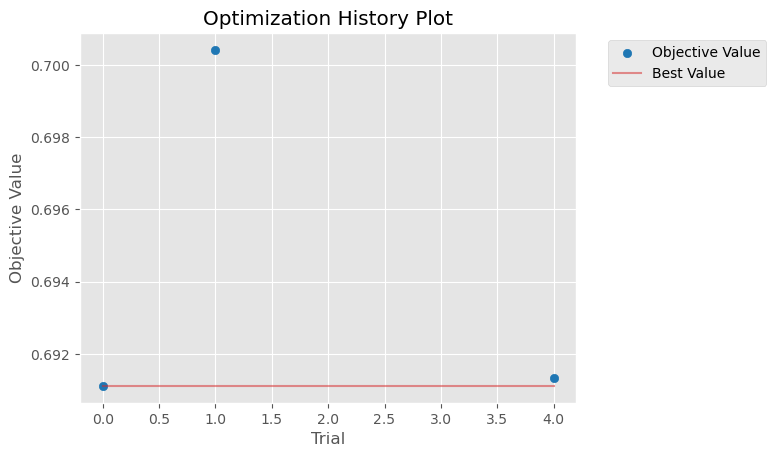

In [ ]:
# Cell [ ]: resume_and_plot.py

import os, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import optuna
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

# -------------- 1. load study from disk ------------------------
storage_name = "sqlite:///optuna_study.db"
study_name   = "cnn_pruning_study"
study = optuna.load_study(study_name=study_name, storage=storage_name)

history = study.user_attrs["history"]

print(f"Loaded study '{study_name}' with {len(study.trials)} trials")
print("Best params so far:", study.best_params)
print(f"Best CV loss = {study.best_value:.4f}")

# -------------- 2. re‐plot overall optimization history -------------
fig = plot_optimization_history(study)
fig.tight_layout()
fig.savefig("figures/opt_history_overall.png")
plt.show()
plt.close(fig)

fig = plot_param_importances(study)
fig.tight_layout()
fig.savefig("figures/param_importances_overall.png")
plt.show()
plt.close(fig)

# -------------- 3. define exactly the same CNN class --------------
import sys
sys.path.append(
    r"C:\Users\flori\OneDrive - TU Eindhoven\Master TUe 2024-2025\1BM120 - Decision Making with Artificial Intelligence\Assignment 2"
)
from support import load_dataset

trainset, testset = load_dataset()
num_classes = len(trainset.classes)

class CNN_CV(nn.Module):
    def __init__(self, n_cls, pooltype=0):
        super().__init__()
        self.conv1  = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1  = nn.ReLU()
        if pooltype == 0:
            self.pool1 = nn.MaxPool2d(2, 2)
        else:
            self.pool1 = nn.AvgPool2d(2, 2)

        self.conv2  = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.relu2  = nn.ReLU()
        if pooltype == 0:
            self.pool2 = nn.MaxPool2d(2, 2)
        else:
            self.pool2 = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 15 * 7, n_cls)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        return self.fc1(x)

# -------------- 4. train the best‐so‐far model on full training set ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best = study.best_params

# unpack best params
lr       = best["lr"]
wd       = best["wd"]
pooltype = best["pool"]
bs       = best["bs"]
ep       = best["ep"]

print("Training final model with best‐found hyperparameters:")
print(f"  lr={lr:.1e}, wd={wd:.1e}, pool={pooltype}, bs={bs}, epochs={ep}\n")

train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

model_final = CNN_CV(num_classes, pooltype).to(device)
optimizer_final = optim.Adam(model_final.parameters(), lr=lr, weight_decay=wd)
criterion_final = nn.CrossEntropyLoss()

# training loop
for epoch in range(1, ep + 1):
    model_final.train()
    running_loss = 0.0
    correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer_final.zero_grad()
        logits = model_final(xb)
        loss = criterion_final(logits, yb)
        loss.backward()
        optimizer_final.step()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc  = 100.0 * correct / len(trainset)
    print(f"Epoch {epoch:02d}/{ep}  |  Train loss={train_loss:.4f}, Train acc={train_acc:.1f}%")

print("\nFinished training final model.\n")

# -------------- 5. evaluate on test set ------------------------
model_final.eval()
all_preds = []
all_lbls  = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_final(xb).cpu()
        all_preds.append(logits.argmax(dim=1))
        all_lbls.append(yb)

all_preds = torch.cat(all_preds).numpy()
all_lbls  = torch.cat(all_lbls).numpy()

cm = confusion_matrix(all_lbls, all_preds, labels=list(range(num_classes)))
fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=trainset.classes)
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
ax_cm.set_title("Confusion matrix (test set) — Final model")
fig_cm.tight_layout()
fig_cm.savefig("figures/confusion_matrix_final.png")
plt.show()
plt.close(fig_cm)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(num_classes), per_class_acc)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(trainset.classes, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.set_ylabel("accuracy")
ax.set_title("Per‐class accuracy (test set) — Final model")
fig.tight_layout()
fig.savefig("figures/per_class_accuracy_final.png")
plt.show()
plt.close(fig)

# -------------- 6. (Optional) plot validation‐curves for each trial ------------
# You can iterate through history if you want more detailed per‐trial analysis,
# but generally the above plots suffice.

import os

# Make sure the directory for per‐trial plots exists
os.makedirs("figures/validation_curves", exist_ok=True)

for i, (tr_curve, vl_curve) in enumerate(zip(history["train_curve"], history["val_curve"]), start=1):
    epochs_i = range(1, len(tr_curve) + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs_i, tr_curve, label="train")
    ax.plot(epochs_i, vl_curve, label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"Trial {i}  —  Validation Curves")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"figures/validation_curves/trial_{i}_val_curve.png")
    plt.close(fig)

print("All diagnostics + final model plots are saved under ./figures")
print("Notebook cell complete.")

In [ ]:
"""
CNN classifier with baseline training and Optuna hyper-parameter search.
Plots are now saved after *every* Optuna trial.
"""

import os
import random
import logging
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from support import load_dataset           # ← your helper that returns (train_dataset, test_dataset)

# ------------------------------------------------------------------
# 0. Logging configuration
# ------------------------------------------------------------------
logging.basicConfig(
    level=os.getenv("LOGLEVEL", "INFO").upper(),
    format="%(asctime)s | %(levelname)-8s | %(message)s",
    datefmt="%H:%M:%S",
    force=True,              # override any previous basicConfig
)
logger = logging.getLogger(__name__)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

# NEW ───────────────────────────────────────────────────────────────
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)      # ensure folder exists
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 1. Reproducibility utilities
# ------------------------------------------------------------------
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"      # harmless everywhere


def set_seed(seed: int = 18) -> None:
    """Seed Python, NumPy, PyTorch (CPU & CUDA) for deterministic runs."""
    logger.debug(f"Setting global seed to {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed()

# ------------------------------------------------------------------
# 2. Load datasets
# ------------------------------------------------------------------
logger.info("Loading datasets …")
train_dataset, test_dataset = load_dataset()
logger.info(f"Dataset sizes — train: {len(train_dataset)}  |  test: {len(test_dataset)}")

# Default DataLoaders (will be overridden by trial-specific batch sizes)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ------------------------------------------------------------------
# 3. Training / evaluation helpers
# ------------------------------------------------------------------
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    """Runs a single epoch and returns (loss, accuracy)."""
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = correct / len(loader.dataset)
    return epoch_loss, epoch_acc


@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """Returns accuracy (0–1) on `loader`."""
    model.eval()
    correct = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    return correct / len(loader.dataset)


def plot_learning_curve(
    train_accs: List[float],
    train_losses: List[float],
    title: str,
) -> None:
    """Quick Matplotlib learning curve with best-epoch highlight."""
    epochs = range(1, len(train_accs) + 1)
    best_epoch = int(np.argmax(train_accs))
    best_acc   = train_accs[best_epoch]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_accs,   label="Train accuracy")
    plt.plot(epochs, train_losses, label="Train loss")
    plt.scatter(
        best_epoch + 1,
        best_acc,
        c="red",
        s=80,
        label=f"Best acc: {best_acc:.3f} (epoch {best_epoch+1})",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def train_and_evaluate(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    num_epochs: int,
    prefix: str,
) -> Tuple[List[float], List[float], int, float]:
    """
    Train `model` for `num_epochs` and evaluate on `test_loader`.
    Returns (train_losses, train_accs, best_epoch, test_acc).
    """
    logger.info(f"[{prefix}] ➜ Starting training for {num_epochs} epochs")
    train_losses, train_accs = [], []

    for epoch in range(num_epochs):
        loss, acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)
        train_accs.append(acc)
        logger.info(f"[{prefix}] Epoch {epoch+1:02}/{num_epochs} — loss: {loss:.4f}  acc: {acc:.4f}")

    best_epoch = int(np.argmax(train_accs))
    best_acc   = train_accs[best_epoch]
    logger.info(f"[{prefix}] Best training acc: {best_acc:.4f} (epoch {best_epoch+1})")

    test_acc = evaluate(model, test_loader, device)
    logger.info(f"[{prefix}] Test accuracy: {test_acc:.4f}")

    return train_losses, train_accs, best_epoch, test_acc

# ------------------------------------------------------------------
# 4. CNN architecture
# ------------------------------------------------------------------
class CNN(nn.Module):
    def __init__(self, num_filters: int = 16, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters * 2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Infer flattened size dynamically (expects 3×60×30 inputs)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 60, 30)
            flat_features = self.features(dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        return self.classifier(x)

# ------------------------------------------------------------------
# 5. Baseline training
# ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

baseline_model     = CNN(num_filters=16, dropout=0.5).to(device)
baseline_criterion = nn.CrossEntropyLoss()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)
num_epochs_baseline = 10

bl_losses, bl_accs, bl_best_epoch, bl_test_acc = train_and_evaluate(
    baseline_model,
    train_loader,
    test_loader,
    baseline_criterion,
    baseline_optimizer,
    device,
    num_epochs_baseline,
    prefix="Baseline",
)

plot_learning_curve(bl_accs, bl_losses, "Baseline learning curve")

# ------------------------------------------------------------------
# 6. Optuna hyper-parameter tuning (5-fold CV)
# ------------------------------------------------------------------
logger.info("Starting Optuna hyper-parameter search …")

def objective(trial: optuna.trial.Trial) -> float:
    # Suggest parameters
    lr          = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout     = trial.suggest_float("dropout", 0.1, 0.7)
    optimizer   = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size  = trial.suggest_categorical("batch_size", [16, 32])
    num_filters = trial.suggest_int("num_filters", 16, 64, step=16)

    logger.debug(
        f"[Trial {trial.number}] lr={lr:.2e}, dropout={dropout:.2f}, "
        f"optimizer={optimizer}, batch={batch_size}, filters={num_filters}"
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=18)
    fold_accs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset))), 1):
        train_subset = Subset(train_dataset, train_idx)
        val_subset   = Subset(train_dataset, val_idx)

        train_loader_cv = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader_cv   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

        model_cv = CNN(num_filters=num_filters, dropout=dropout).to(device)
        criterion_cv = nn.CrossEntropyLoss()
        optim_cls = optim.Adam if optimizer == "Adam" else optim.SGD
        optimizer_cv = optim_cls(model_cv.parameters(), lr=lr)

        for _ in range(5):  # few epochs for CV
            train_one_epoch(model_cv, train_loader_cv, criterion_cv, optimizer_cv, device)

        val_acc = evaluate(model_cv, val_loader_cv, device)
        fold_accs.append(val_acc)
        logger.debug(f"[Trial {trial.number}] fold {fold}: val_acc={val_acc:.4f}")

    mean_acc = float(np.mean(fold_accs))
    logger.debug(f"[Trial {trial.number}] mean 5-fold acc: {mean_acc:.4f}")
    return mean_acc

# ------------------------------------------------------------------
# 7. Validation-curve helpers + per-trial callbacks  ← NEW
# ------------------------------------------------------------------
def save_study_progress_plot(study: optuna.Study, title: str, filepath: str) -> None:
    """Draw current validation curve for `study` and write to `filepath`."""
    trials = study.trials
    xs = [t.number for t in trials]
    ys = [t.value for t in trials]

    plt.figure(figsize=(6, 4))
    plt.plot(xs, ys, marker="o")
    best = study.best_trial
    plt.scatter(best.number, best.value, c="red", s=100,
                label=f"Best (trial {best.number})")
    plt.xlabel("Trial #")
    plt.ylabel("Mean 5-fold CV accuracy")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()
    logger.debug(f"Saved plot ➜ {filepath}")

def make_progress_callback(prefix: str):
    """Factory returning a callback that saves a plot after each trial."""
    def _callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
        fname = f"{prefix}_progress_trial_{trial.number:03}.png"
        fpath = os.path.join(PLOTS_DIR, fname)
        save_study_progress_plot(
            study,
            f"{prefix} validation curve (up to trial {trial.number})",
            fpath,
        )
    return _callback

# ------------------------------------------------------------------
# 8. Random-search study ▸ 40 trials
# ------------------------------------------------------------------
random_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.RandomSampler(seed=18),
)
random_study.optimize(
    objective,
    n_trials=40,
    show_progress_bar=True,
    callbacks=[make_progress_callback("random")],   # ← NEW
)

# ------------------------------------------------------------------
# 9. TPE study ▸ 40 trials
# ------------------------------------------------------------------
tpe_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=18),
)
tpe_study.optimize(
    objective,
    n_trials=40,
    show_progress_bar=True,
    callbacks=[make_progress_callback("tpe")],      # ← NEW
)

logger.info(f"Random-search best params: {random_study.best_params}")
logger.info(f"Random-search best CV acc: {random_study.best_value:.4f}")
logger.info(f"TPE best params         : {tpe_study.best_params}")
logger.info(f"TPE best CV acc         : {tpe_study.best_value:.4f}")

# ------------------------------------------------------------------
# 10. Final “static” validation curves (complete)
# ------------------------------------------------------------------
def _plot_val_curve(study: optuna.Study, title: str) -> None:
    trials = study.trials
    xs = [t.number for t in trials]
    ys = [t.value for t in trials]
    plt.figure(figsize=(6, 4))
    plt.plot(xs, ys, marker="o")
    best = study.best_trial
    plt.scatter(best.number, best.value, c="red", s=100,
                label=f"Best (trial {best.number})")
    plt.xlabel("Trial #")
    plt.ylabel("Mean 5-fold CV accuracy")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

_plot_val_curve(random_study, "Random search validation curve (40 trials)")
_plot_val_curve(tpe_study,    "TPE validation curve (40 trials)")

# ------------------------------------------------------------------
# 11. Retrain final model with TPE best hyper-parameters
# ------------------------------------------------------------------
logger.info("Retraining full model with TPE-selected parameters …")
best_tpe = tpe_study.best_params
final_model_tpe = CNN(
    num_filters=best_tpe["num_filters"],
    dropout=best_tpe["dropout"],
).to(device)

criterion_tpe = nn.CrossEntropyLoss()
optim_cls_tpe = optim.Adam if best_tpe["optimizer"] == "Adam" else optim.SGD
optimizer_tpe = optim_cls_tpe(final_model_tpe.parameters(), lr=best_tpe["lr"])

full_train_loader_tpe = DataLoader(train_dataset,
                                   batch_size=best_tpe["batch_size"],
                                   shuffle=True)

tpe_losses, tpe_accs, tpe_best_epoch, tpe_test_acc = train_and_evaluate(
    final_model_tpe,
    full_train_loader_tpe,
    test_loader,
    criterion_tpe,
    optimizer_tpe,
    device,
    num_epochs=20,
    prefix="TPE-final",
)

plot_learning_curve(tpe_accs, tpe_losses, "Learning curve — final TPE model")

# ------------------------------------------------------------------
# 12. Retrain final model with Random-search best hyper-parameters
# ------------------------------------------------------------------
logger.info("Retraining full model with Random-search-selected parameters …")
best_rs = random_study.best_params
final_model_rs = CNN(
    num_filters=best_rs["num_filters"],
    dropout=best_rs["dropout"],
).to(device)

criterion_rs = nn.CrossEntropyLoss()
optim_cls_rs = optim.Adam if best_rs["optimizer"] == "Adam" else optim.SGD
optimizer_rs = optim_cls_rs(final_model_rs.parameters(), lr=best_rs["lr"])

full_train_loader_rs = DataLoader(train_dataset,
                                  batch_size=best_rs["batch_size"],
                                  shuffle=True)

rs_losses, rs_accs, rs_best_epoch, rs_test_acc = train_and_evaluate(
    final_model_rs,
    full_train_loader_rs,
    test_loader,
    criterion_rs,
    optimizer_rs,
    device,
    num_epochs=20,
    prefix="RS-final",
)

plot_learning_curve(rs_accs, rs_losses, "Learning curve — final Random-search model")

# ------------------------------------------------------------------
# 13. Persist models
# ------------------------------------------------------------------
logger.info("Saving final model weights …")
torch.save(final_model_tpe.state_dict(), "cnn_final_tpe_5foldcv.pth")
torch.save(final_model_rs.state_dict(),  "cnn_final_rs_5foldcv.pth")
logger.info("Done! 🚀")


22:17:44 | INFO     | Loading datasets …
22:17:44 | INFO     | Dataset sizes — train: 136  |  test: 34
22:17:44 | INFO     | Using device: cuda


22:17:44 | INFO     | [Baseline] ➜ Starting training for 20 epochs
22:18:14 | INFO     | [Baseline] Epoch 01/20 — loss: 0.7053  acc: 0.4118
22:18:45 | INFO     | [Baseline] Epoch 02/20 — loss: 0.6930  acc: 0.5147
22:19:16 | INFO     | [Baseline] Epoch 03/20 — loss: 0.6910  acc: 0.5441
22:19:44 | INFO     | [Baseline] Epoch 04/20 — loss: 0.6819  acc: 0.6029
22:20:14 | INFO     | [Baseline] Epoch 05/20 — loss: 0.6618  acc: 0.6985
22:20:44 | INFO     | [Baseline] Epoch 06/20 — loss: 0.6340  acc: 0.7206
22:21:16 | INFO     | [Baseline] Epoch 07/20 — loss: 0.5776  acc: 0.7279
22:21:51 | INFO     | [Baseline] Epoch 08/20 — loss: 0.5757  acc: 0.7059


KeyboardInterrupt: 

[Baseline] Epoch 01 | loss=0.7053 acc=0.4118
[Baseline] Epoch 02 | loss=0.6930 acc=0.5147
[Baseline] Epoch 03 | loss=0.6910 acc=0.5441
[Baseline] Epoch 04 | loss=0.6819 acc=0.6029
[Baseline] Epoch 05 | loss=0.6618 acc=0.6985
[Baseline] Epoch 06 | loss=0.6340 acc=0.7206
[Baseline] Epoch 07 | loss=0.5776 acc=0.7279
[Baseline] Epoch 08 | loss=0.5757 acc=0.7059
[Baseline] Epoch 09 | loss=0.6240 acc=0.6618
[Baseline] Epoch 10 | loss=0.5308 acc=0.7574
[Baseline] Best train acc 0.7574 @ epoch 10
[Baseline] Final test acc 0.5588


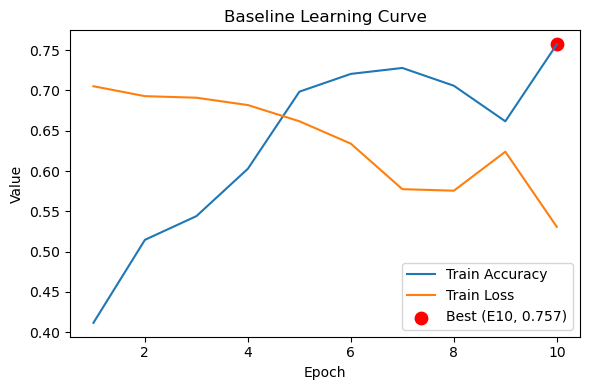

[I 2025-06-03 23:09:18,791] A new study created in memory with name: no-name-8d252254-e7eb-42e0-a8d1-7bb13f225867
[I 2025-06-03 23:42:45,092] Trial 0 finished with value: 0.8894179894179894 and parameters: {'lr': 0.0008935579543655974, 'dropout': 0.4032720242409057, 'optimizer': 'Adam', 'batch_size': 16, 'num_filters': 48}. Best is trial 0 with value: 0.8894179894179894.
[I 2025-06-04 00:15:58,693] Trial 1 finished with value: 0.40476190476190477 and parameters: {'lr': 0.009197850467534774, 'dropout': 0.2541810535622981, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 16}. Best is trial 0 with value: 0.8894179894179894.
[I 2025-06-04 00:49:55,277] Trial 2 finished with value: 0.44179894179894175 and parameters: {'lr': 2.1617695339723554e-05, 'dropout': 0.27863424511351587, 'optimizer': 'SGD', 'batch_size': 32, 'num_filters': 48}. Best is trial 0 with value: 0.8894179894179894.
[I 2025-06-04 01:24:46,319] Trial 3 finished with value: 0.7936507936507936 and parameters: {'lr': 0.0001

KeyboardInterrupt: 

In [1]:
# ============================================================
# 0 . User-tunable parameters
# ============================================================
# Reproducibility
SEED = 18                        # random-seed for Python / NumPy / PyTorch

# Data & model
INPUT_SIZE        = (3, 60, 30)  # C × H × W –​ used for dummy tensor
BASE_BATCH_SIZE   = 16           # baseline training
NUM_EPOCHS_BASE   = 10           # baseline
KFOLDS            = 5            # CV folds
NUM_EPOCHS_CV     = 20            # per-fold epoch count during Optuna trials
NUM_EPOCHS_FINAL  = 20           # retrain with best hyper-params

# Hyper-parameter search
N_TRIALS_RS       = 30           # RandomSampler trials
N_TRIALS_TPE      = 30           # TPESampler trials
HYPERPARAMS_SPACE = {
    "lr":         (1e-5, 1e-2, "log"),                # (low, high, scale)
    "dropout":    (0.1, 0.7),
    "optimizer":  ["Adam", "SGD"],
    "batch_size": [16, 32],
    "num_filters": (16, 64, 16)                       # (low, high, step)
}

# Plotting
PLOT_DIR          = "plots"       # folder where every figure is stored
PLOT_FORMAT       = "png"         # png / pdf / svg …
SHOW_FIGS_ONLINE  = True          # set False if running on headless node

# ============================================================
# 1 . Imports & housekeeping
# ============================================================
import os, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from support import load_dataset              # <- your own helper

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# 1.a  Reproducibility helper
# ------------------------------------------------------------
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

set_seed(SEED)

# ============================================================
# 2 . Load dataset & create baseline loaders
# ============================================================
train_dataset, test_dataset = load_dataset()
train_loader = DataLoader(train_dataset, batch_size=BASE_BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BASE_BATCH_SIZE, shuffle=False)

# ============================================================
# 3 .  Training utilities
# ============================================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train(); running_loss = 0.0; correct = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss   = criterion(logits, y)
        loss.backward(); optimizer.step()

        running_loss += loss.item() * X.size(0)
        correct      += (logits.argmax(1) == y).sum().item()

    n = len(loader.dataset)
    return running_loss / n, correct / n

@torch.inference_mode()
def evaluate(model, loader, device):
    model.eval(); correct = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        correct += (model(X).argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

def save_current_fig(filename: str):
    """Helper to save *and optionally show* the active Matplotlib figure."""
    plt.tight_layout()
    plt.savefig(Path(PLOT_DIR, filename), format=PLOT_FORMAT, dpi=300)
    if SHOW_FIGS_ONLINE:
        plt.show()
    else:
        plt.close()

def plot_learning_curve(accs, losses, title, fname):
    epochs      = range(1, len(accs) + 1)
    best_idx    = int(np.argmax(accs))
    best_acc    = accs[best_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, accs,   label="Train Accuracy")
    plt.plot(epochs, losses, label="Train Loss")
    plt.scatter(best_idx+1, best_acc, color="red", s=80,
                label=f"Best (E{best_idx+1}, {best_acc:.3f})")
    plt.xlabel("Epoch"); plt.ylabel("Value"); plt.title(title); plt.legend()
    save_current_fig(fname)

def train_and_evaluate(model, train_loader, test_loader,
                       criterion, optimizer, device,
                       num_epochs, prefix):
    accs, losses = [], []
    for epoch in range(num_epochs):
        loss, acc = train_one_epoch(model, train_loader,
                                    criterion, optimizer, device)
        losses.append(loss); accs.append(acc)
        print(f"[{prefix}] Epoch {epoch+1:02d} | loss={loss:.4f} acc={acc:.4f}")

    best_idx = int(np.argmax(accs))
    print(f"[{prefix}] Best train acc {accs[best_idx]:.4f} @ epoch {best_idx+1}")

    test_acc = evaluate(model, test_loader, device)
    print(f"[{prefix}] Final test acc {test_acc:.4f}")

    return losses, accs, best_idx, test_acc

# ============================================================
# 4 .  CNN definition
# ============================================================
class CNN(nn.Module):
    def __init__(self, num_filters: int = 16, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters*2, 3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2)
        )
        # compute flattened size dynamically
        with torch.no_grad():
            dummy  = torch.zeros(1, *INPUT_SIZE)
            flat   = self.features(dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat, 128), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def forward(self, x): return self.classifier(self.features(x))

# ============================================================
# 5 .  Baseline experiment
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline.parameters(), lr=1e-3)

bl_loss, bl_acc, bl_best, bl_test = train_and_evaluate(
    baseline, train_loader, test_loader, criterion, optimizer,
    DEVICE, NUM_EPOCHS_BASE, prefix="Baseline"
)
plot_learning_curve(bl_acc, bl_loss,
                    title="Baseline Learning Curve",
                    fname="baseline_learning_curve.png")

# ============================================================
# 6 .  Optuna objective
# ============================================================
def objective(trial):
    lr_low, lr_high, lr_scale     = HYPERPARAMS_SPACE["lr"]
    dropout_low, dropout_high     = HYPERPARAMS_SPACE["dropout"]
    nFilt_low, nFilt_high, n_step = HYPERPARAMS_SPACE["num_filters"]

    lr          = trial.suggest_float("lr", lr_low, lr_high, log=(lr_scale=="log"))
    dropout     = trial.suggest_float("dropout", dropout_low, dropout_high)
    optimizerNm = trial.suggest_categorical("optimizer", HYPERPARAMS_SPACE["optimizer"])
    batch_size  = trial.suggest_categorical("batch_size", HYPERPARAMS_SPACE["batch_size"])
    num_filters = trial.suggest_int("num_filters", nFilt_low, nFilt_high, step=n_step)

    kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)
    fold_accs = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
        tr_loader = DataLoader(Subset(train_dataset, tr_idx),
                               batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_idx),
                                batch_size=batch_size, shuffle=False)

        model = CNN(num_filters=num_filters, dropout=dropout).to(DEVICE)
        crit  = nn.CrossEntropyLoss()
        opt   = (optim.Adam(model.parameters(), lr=lr)
                 if optimizerNm=="Adam" else
                 optim.SGD(model.parameters(), lr=lr))

        for _ in range(NUM_EPOCHS_CV):
            train_one_epoch(model, tr_loader, crit, opt, DEVICE)
        fold_accs.append(evaluate(model, val_loader, DEVICE))

    return float(np.mean(fold_accs))

# ============================================================
# 7 .  Random search & TPE
# ============================================================
rs_study = optuna.create_study(direction="maximize",
                               sampler=optuna.samplers.RandomSampler(seed=SEED))
rs_study.optimize(objective, n_trials=N_TRIALS_RS)

tpe_study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=SEED))
tpe_study.optimize(objective, n_trials=N_TRIALS_TPE)

print("\nBest (Random):", rs_study.best_params,
      f"CV Acc={rs_study.best_value:.4f}")
print("Best (TPE):   ", tpe_study.best_params,
      f"CV Acc={tpe_study.best_value:.4f}")

# Validation-curve helper
def plot_validation_curve(study, title, fname):
    nums   = [t.number for t in study.trials]
    values = [t.value  for t in study.trials]
    best   = study.best_trial
    plt.figure(figsize=(6,4))
    plt.plot(nums, values, marker="o")
    plt.scatter(best.number, best.value, s=100, c="red",
                label=f"Best (T{best.number})")
    plt.xlabel("Trial"); plt.ylabel("Mean CV Acc"); plt.title(title)
    plt.legend(); save_current_fig(fname)

plot_validation_curve(rs_study,  "Random Search (20 trials)",
                      "rs_validation_curve.png")
plot_validation_curve(tpe_study, "TPE (20 trials)",
                      "tpe_validation_curve.png")

# ============================================================
# 8 .  Retrain with best TPE hyper-params
# ============================================================
bp = tpe_study.best_params
tpe_model = CNN(num_filters=bp["num_filters"], dropout=bp["dropout"]).to(DEVICE)
crit = nn.CrossEntropyLoss()
opt  = (optim.Adam(tpe_model.parameters(), lr=bp["lr"])
        if bp["optimizer"]=="Adam"
        else optim.SGD(tpe_model.parameters(), lr=bp["lr"]))
loader = DataLoader(train_dataset, batch_size=bp["batch_size"], shuffle=True)

tpe_loss, tpe_acc, _, tpe_test = train_and_evaluate(
    tpe_model, loader, test_loader, crit, opt, DEVICE,
    NUM_EPOCHS_FINAL, prefix="TPE-final"
)
plot_learning_curve(tpe_acc, tpe_loss,
                    "Learning Curve (TPE final)",
                    "tpe_final_learning_curve.png")

# ============================================================
# 9 .  Retrain with best Random-search hyper-params
# ============================================================
bp = rs_study.best_params
rs_model = CNN(num_filters=bp["num_filters"], dropout=bp["dropout"]).to(DEVICE)
crit = nn.CrossEntropyLoss()
opt  = (optim.Adam(rs_model.parameters(), lr=bp["lr"])
        if bp["optimizer"]=="Adam"
        else optim.SGD(rs_model.parameters(), lr=bp["lr"]))
loader = DataLoader(train_dataset, batch_size=bp["batch_size"], shuffle=True)

rs_loss, rs_acc, _, rs_test = train_and_evaluate(
    rs_model, loader, test_loader, crit, opt, DEVICE,
    NUM_EPOCHS_FINAL, prefix="RS-final"
)
plot_learning_curve(rs_acc, rs_loss,
                    "Learning Curve (RS final)",
                    "rs_final_learning_curve.png")

# ============================================================
# 10 .  Save model weights
# ============================================================
torch.save(tpe_model.state_dict(), Path("cnn_final_tpe_5foldcv.pth"))
torch.save(rs_model.state_dict(),  Path("cnn_final_rs_5foldcv.pth"))
print("\nAll done – plots saved to", Path(PLOT_DIR).resolve())
